# Initial Experiments with Complex Synapses
- Single complex neuron, Oja rule, input statistics follows a "white" and global random variation.

In [41]:
%load_ext autoreload
%autoreload 2

import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy.random as random
from neuron import Neuron, Log
from simulation import Simulator
from util import get_combinations
from collections import namedtuple
from collections import OrderedDict
import pickle


plt.rcParams.update({'font.size': 14})
pltaspect = (4,3)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
neuron_parameters = OrderedDict(
    N = [10],
    S = [5],
    tau_W=[1],
    beta = [1],
    n = [2]
)

neurons = []
for p in get_combinations(neuron_parameters):
    neurons.append(Neuron(p.N, p.S, p.tau_W, p.beta, p.n))


In [26]:
timescales = neurons[0].tau_W * (-1) / np.linalg.eigvals(neurons[0].L)
timescales

array([   1.24821916,    6.51204096,   29.03089078, 1140.53578149,
        124.67306761])

The choice of `dt` in the next block is dependent on the time-scales shown here. Approx. 1 order of magnitude smaller than the fastest mode is usually sufficient.

In [43]:
env_parameters = OrderedDict(
    sigma_s = [1],
    epsilon = [0.1, 0.4, 1.6],
    # epsilon = [0.1],
    sigma_y = [1],
    T_e = [10, 20, 50, 100]
    # T_e = [100]
)

envs = []
for p in get_combinations(env_parameters):
    envs.append(Simulator(p.sigma_s, p.epsilon, p.sigma_y, p.T_e, dt=0.01))


It appears that value of $\epsilon$ also affects the choice of time-step length. Keeping all the other parameters same as before, a larger $\epsilon$ resulted in unstable runs (nan values), but the issue goes away when time-step length is reduced by 1 order.

In [44]:
trials = OrderedDict(
    neuron = neurons,
    env = envs
)


T = 10 * max(env_parameters['T_e'])
# run all the combinations available
for trial in get_combinations(trials):
    trial.env.run(trial.neuron, T=T)





In [45]:
for neuron in neurons:
    print(neuron)

Properties: {'N': 10, 'S': 5, 'tau_W': 1, 'beta': 1, 'n': 2, 'alpha': 1}.
Trials: 
0: {'sigma': 1, 'epsilon': 0.1, 'T_e': 10, 'mode': 'block', 'T': 1000, 'dt': 0.01}. 
1: {'sigma': 1, 'epsilon': 0.1, 'T_e': 20, 'mode': 'block', 'T': 1000, 'dt': 0.01}. 
2: {'sigma': 1, 'epsilon': 0.1, 'T_e': 50, 'mode': 'block', 'T': 1000, 'dt': 0.01}. 
3: {'sigma': 1, 'epsilon': 0.1, 'T_e': 100, 'mode': 'block', 'T': 1000, 'dt': 0.01}. 
4: {'sigma': 1, 'epsilon': 0.4, 'T_e': 10, 'mode': 'block', 'T': 1000, 'dt': 0.01}. 
5: {'sigma': 1, 'epsilon': 0.4, 'T_e': 20, 'mode': 'block', 'T': 1000, 'dt': 0.01}. 
6: {'sigma': 1, 'epsilon': 0.4, 'T_e': 50, 'mode': 'block', 'T': 1000, 'dt': 0.01}. 
7: {'sigma': 1, 'epsilon': 0.4, 'T_e': 100, 'mode': 'block', 'T': 1000, 'dt': 0.01}. 
8: {'sigma': 1, 'epsilon': 1.6, 'T_e': 10, 'mode': 'block', 'T': 1000, 'dt': 0.01}. 
9: {'sigma': 1, 'epsilon': 1.6, 'T_e': 20, 'mode': 'block', 'T': 1000, 'dt': 0.01}. 
10: {'sigma': 1, 'epsilon': 1.6, 'T_e': 50, 'mode': 'block', 'T':

In [50]:
with open('../data/neurons.pkl', 'wb') as f:
    pickle.dump(neurons, f)

In [52]:
with open('../data/neurons.pkl', 'rb') as f:
    neurons = pickle.load(f)

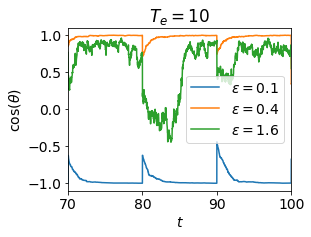

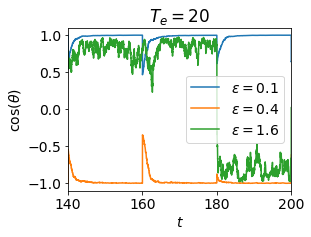

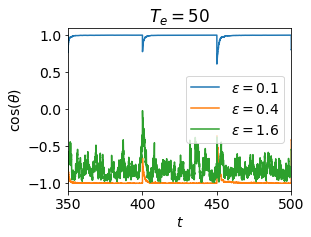

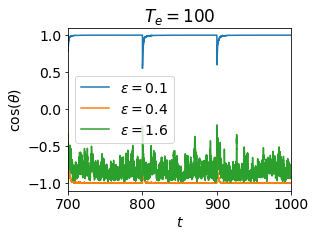

In [53]:
figures = {}
axs = {}

blocks = np.array([7, 10])

for neuron in neurons:
    for log in neuron.logs:
        if log.env_parameters['T_e'] not in figures:
            figures[log.env_parameters['T_e']], axs[log.env_parameters['T_e']] = plt.subplots(
                figsize=pltaspect
            )
            axs[log.env_parameters['T_e']].set_xlabel('$t$')
            axs[log.env_parameters['T_e']].set_ylabel('$\cos(\\theta)$')
            axs[log.env_parameters['T_e']].set_title(
                '$T_e =${}'.format(log.env_parameters['T_e'])
            )

        axs[log.env_parameters['T_e']].plot(
            log.timeline, 
            (log.w_para/log.w_norm), 
            label = '$\epsilon =${}'.format(log.env_parameters['epsilon']),
        )
        axs[log.env_parameters['T_e']].set_xlim(*(log.env_parameters['T_e'] * blocks))
        if log.env_parameters['epsilon'] == 2.5:
            print(log.w_para/log.w_norm)

for ax in axs.values():
    ax.legend()
        
    

Plotting different 'beakers':

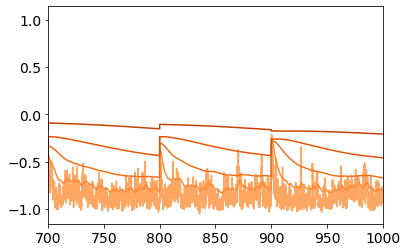

In [54]:
cm_section = np.linspace(0.4, 0.8, neurons[0].S)
colors = [ cm.Oranges(x) for x in cm_section ]

log_index = 11

blocks = np.array([7, 10])

fig, ax = plt.subplots()
for i in np.arange(0, neurons[0].S, 1):
    ax.plot(neurons[0].logs[log_index].timeline, (neurons[0].logs[log_index].W[:, [i], :] @ neurons[0].logs[log_index].y).squeeze(), color = colors[i])
    ax.set_xlim(*(neurons[0].logs[log_index].env_parameters['T_e'] * blocks))

Next block plots a grid of subplots, each subplot being the plot shown above for a different trial.

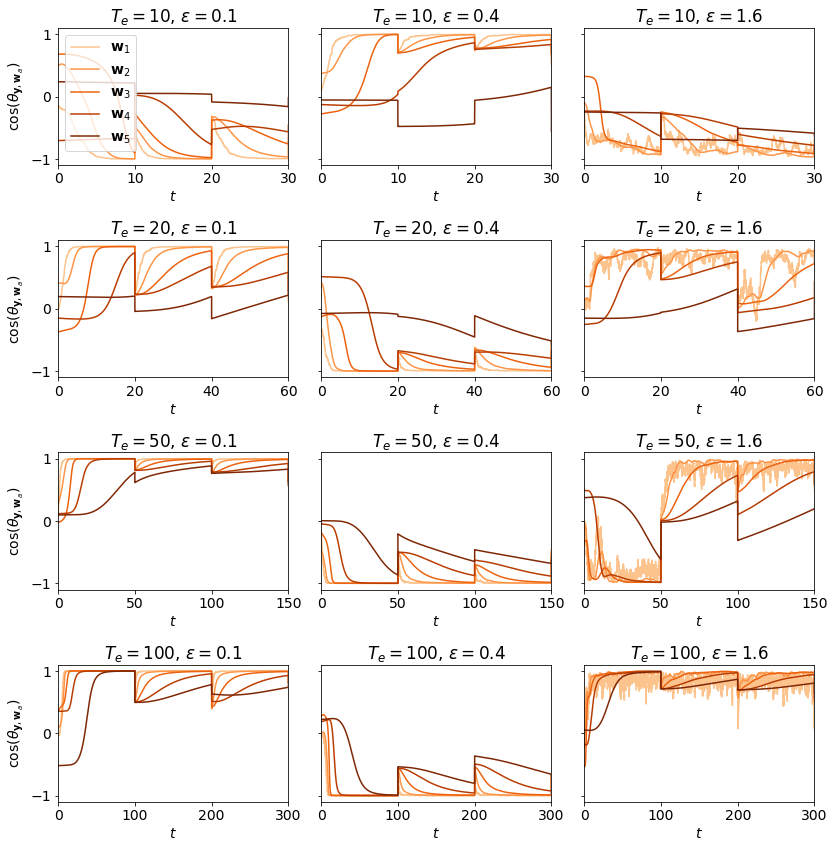

In [55]:
cm_section = np.linspace(0.3, 1, neurons[0].S)
colors = [ cm.Oranges(x) for x in cm_section ]

fig1, axs1 = plt.subplots(len(env_parameters['T_e']), len(env_parameters['epsilon']), squeeze=True, figsize=(12,12), sharey=True)

for i, T_e in enumerate(env_parameters['T_e']):
    for j, epsilon in enumerate(env_parameters['epsilon']):
        for log in neurons[0].logs:
            if log.env_parameters['T_e'] == T_e and log.env_parameters['epsilon'] == epsilon:
                for k in np.arange(0, neurons[0].S, 1):
                    axs1[i, j].plot(
                        log.timeline, 
                        (log.W[:, [k], :] @ log.y / np.sqrt(log.W[:, [k], :] @ np.transpose(log.W[:, [k], :], (0,2,1)))).squeeze(), 
                        color = colors[k],
                        label = '$\mathbf{{w}}_{{{k}}}$'.format(k=k+1)
                    )
                    axs1[i, j].set_xlabel('$t$', fontsize=14)
                    axs1[i, j].set_title('$T_e = {}$, $\epsilon = {}$'.format(T_e, epsilon))
                axs1[i, j].set_xlim(0, 3*T_e)
                if j == 0:
                    axs1[i, j].set_ylabel('$\cos(\\theta_{{\mathbf{{y}},\mathbf{{w}}_{{a}}}})$', fontsize=14)
                    if i == 0:
                        axs1[i, j].legend(loc="upper left")

fig1.tight_layout()



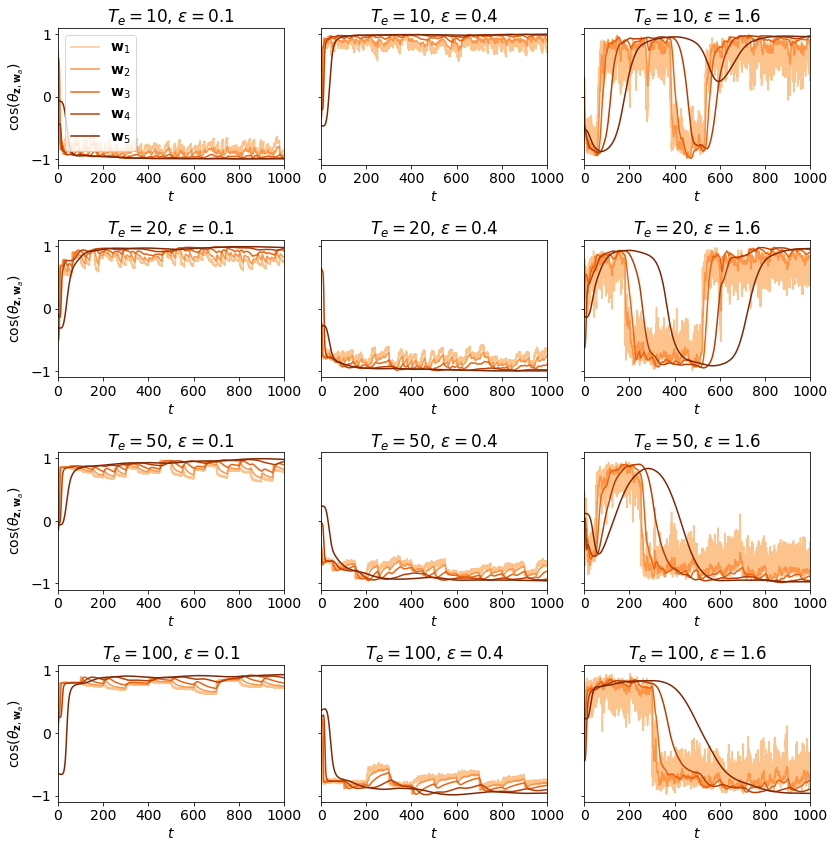

In [56]:
cm_section = np.linspace(0.3, 1, neurons[0].S)
colors = [ cm.Oranges(x) for x in cm_section ]

fig2, axs2 = plt.subplots(len(env_parameters['T_e']), len(env_parameters['epsilon']), squeeze=True, figsize=(12,12), sharey=True)

for i, T_e in enumerate(env_parameters['T_e']):
    for j, epsilon in enumerate(env_parameters['epsilon']):
        for log in neurons[0].logs:
            if log.env_parameters['T_e'] == T_e and log.env_parameters['epsilon'] == epsilon:
                for k in np.arange(0, neurons[0].S, 1):
                    axs2[i, j].plot(
                        log.timeline, 
                        (log.W[:, [k], :] @ log.z / np.sqrt(log.W[:, [k], :] @ np.transpose(log.W[:, [k], :], (0,2,1)))).squeeze(), 
                        color = colors[k],
                        label = '$\mathbf{{w}}_{{{k}}}$'.format(k=k+1)
                    )
                    axs2[i, j].set_xlabel('$t$', fontsize=14)
                    axs2[i, j].set_title('$T_e = {}$, $\epsilon = {}$'.format(T_e, epsilon))
                axs2[i, j].set_xlim(0, T)
                if j == 0:
                    axs2[i, j].set_ylabel('$\cos(\\theta_{{\mathbf{{z}},\mathbf{{w}}_{{a}}}})$', fontsize=14)
                    if i == 0:
                        axs2[i, j].legend(loc="upper left")

fig2.tight_layout()


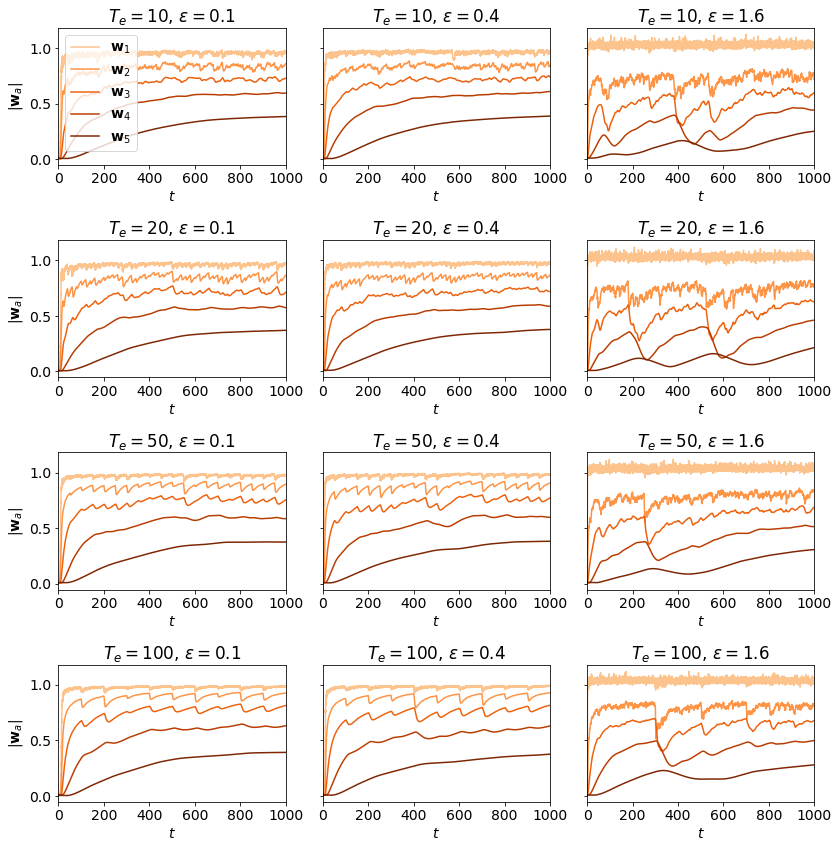

In [57]:
cm_section = np.linspace(0.3, 1, neurons[0].S)
colors = [ cm.Oranges(x) for x in cm_section ]

fig3, axs3 = plt.subplots(len(env_parameters['T_e']), len(env_parameters['epsilon']), squeeze=True, figsize=(12,12), sharey=True)

for i, T_e in enumerate(env_parameters['T_e']):
    for j, epsilon in enumerate(env_parameters['epsilon']):
        for log in neurons[0].logs:
            if log.env_parameters['T_e'] == T_e and log.env_parameters['epsilon'] == epsilon:
                for k in np.arange(0, neurons[0].S, 1):
                    axs3[i, j].plot(
                        log.timeline, 
                        (np.sqrt(log.W[:, [k], :] @ np.transpose(log.W[:, [k], :], (0,2,1)))).squeeze(), 
                        color = colors[k],
                        label = '$\mathbf{{w}}_{{{k}}}$'.format(k=k+1)
                    )
                    axs3[i, j].set_xlabel('$t$', fontsize=14)
                    axs3[i, j].set_title('$T_e = {}$, $\epsilon = {}$'.format(T_e, epsilon))
                axs3[i, j].set_xlim(0, T)
                if j == 0:
                    axs3[i, j].set_ylabel('$| \mathbf{{w}}_{{a}} |$', fontsize=14)
                    if i == 0:
                        axs3[i, j].legend(loc="upper left")

fig3.tight_layout()

In [58]:
fig1.savefig('figures/y_w.pdf', bbox_inches = 'tight')
fig2.savefig('figures/z_w.pdf', bbox_inches = 'tight')
fig3.savefig('figures/norm.pdf', bbox_inches = 'tight')